# Loads (Notice git integration)

In [8]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 2.8MB/s 


In [9]:
!nvidia-smi

Sun Jun 14 14:15:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
import matplotlib

In [0]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.distributions import TransformedDistribution

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual





In [0]:
%matplotlib inline

In [13]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
#from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.flows import ConditionalNormalizingFlowWrapper, ConditionalAffineCoupling

# Load data

In [0]:
two_moons_folder = os.path.join(dataset_folder, 'two_moons')
csv_path = os.path.join(two_moons_folder, 'rotating_two_moons_no_moon_100k_n005.csv')
data_df = pd.read_csv(csv_path)


In [18]:
data_df

,x1,x2,theta
0,-0.302805,1.440689,4.861437
1,-0.569753,-1.165468,4.588591
2,-0.065869,-1.311738,5.019965
3,0.733455,-0.043946,4.253330
4,-0.214984,-0.679081,5.912119
...,...,...,...
99995,1.150161,-0.923861,2.463759
99996,-0.305002,-0.426768,2.725614
99997,-1.406495,-0.168755,0.288765
99998,-1.095531,0.247276,0.361811


# Inverted_conditional_planer (Code is also in python package)

In [0]:
# Based upon implementation from Uber Technologies - Their trademark is below
# Copyright (c) 2017-2019 Uber Technologies, Inc.
# SPDX-License-Identifier: Apache-2.0

import math

import torch
import torch.nn as nn
from torch.distributions import constraints
import torch.nn.functional as F

from torch.distributions import Transform
from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.nn import DenseNN

from pyro.distributions.transforms import permute, batchnorm

@copy_docs_from(Transform)
class InvertedConditionedPlanar(Transform):
    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, bias=None, u=None, w=None):
        super().__init__(cache_size=1)
        self.bias = bias
        self.u = u
        self.w = w
        self._cached_logDetJ = None

    # This method ensures that torch(u_hat, w) > -1, required for invertibility
    def u_hat(self, u, w):
        alpha = torch.matmul(u.unsqueeze(-2), w.unsqueeze(-1)).squeeze(-1)
        a_prime = -1 + F.softplus(alpha)
        return u + (a_prime - alpha) * w.div(w.pow(2).sum(dim=-1, keepdim=True))

    def _call(self, x):
        raise KeyError("ConditionedPlanar object expected to find key in intermediates cache but didn't")
        

    def _inverse(self, y):

        # x ~ (batch_size, dim_size, 1)
        # w ~ (batch_size, 1, dim_size)
        # bias ~ (batch_size, 1)
        act = torch.tanh(torch.matmul(self.w.unsqueeze(-2), y.unsqueeze(-1)).squeeze(-1) + self.bias)
        u_hat = self.u_hat(self.u, self.w)
        x = y + u_hat * act

        psi_z = (1. - act.pow(2)) * self.w
        self._cached_logDetJ = torch.log(
            torch.abs(1 + torch.matmul(psi_z.unsqueeze(-2), u_hat.unsqueeze(-1)).squeeze(-1).squeeze(-1)))
        return x

    def log_abs_det_jacobian(self, x, y):
        x_old, y_old = self._cached_x_y
        if x is not x_old or y is not y_old:
            # This call to the parent class Transform will update the cache
            # as well as calling self._call and recalculating y and log_detJ
            self._inverse(y)

        return -self._cached_logDetJ

class InvertedConditionalPlanar(ConditionalTransformModule):

    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def condition(self, context):
        bias, u, w = self.nn(context)
        return InvertedConditionedPlanar(bias, u, w)

def inverted_conditional_planar(input_dim, context_dim, hidden_dims=None):

    if hidden_dims is None:
        hidden_dims = [input_dim * 10, input_dim * 10]
    nn = DenseNN(context_dim, hidden_dims, param_dims=[1, input_dim, input_dim])
    return InvertedConditionalPlanar(nn)



class InvertedPlanar(InvertedConditionedPlanar, TransformModule):


    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, input_dim):
        super().__init__()

        self.bias = nn.Parameter(torch.Tensor(1,))
        self.u = nn.Parameter(torch.Tensor(input_dim,))
        self.w = nn.Parameter(torch.Tensor(input_dim,))
        self.input_dim = input_dim
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.u.size(0))
        self.w.data.uniform_(-stdv, stdv)
        self.u.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()

In [20]:
inverted_conditional_planar(2, 1)

InvertedConditionalPlanar(
  (nn): DenseNN(
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
      (2): Linear(in_features=20, out_features=5, bias=True)
    )
    (f): ReLU()
  )
)

In [0]:
from DEwNF.flows.ConditionalNormalizingFlowWrapper3 import ConditionalNormalizingFlowWrapper3

def conditional_planar_flow_factory(flow_depth, problem_dim, c_net_depth, c_net_h_dim, context_dim,
                                          context_n_h_dim, context_n_depth, rich_context_dim, batchnorm_momentum, cuda,
                                          coupling_dropout=None, context_dropout=None):
    if cuda:
        base_dist = dist.Normal(torch.zeros(problem_dim).cuda(), torch.ones(problem_dim).cuda())
    else:
        base_dist = dist.Normal(torch.zeros(problem_dim), torch.ones(problem_dim))

    # We define the transformations
    transforms = [inverted_conditional_planar(input_dim=problem_dim,
                                              context_dim=rich_context_dim,
                                              hidden_dims=[c_net_h_dim for i in range(c_net_depth)], # Note array here to create multiple layers in DenseNN
                                            )
                  for i in range(flow_depth)]



    # If we want batchnorm add those in. Then sandwich the steps together to a flow
    if batchnorm_momentum is None:
        batchnorms = None
        flows = transforms
    else:
        batchnorms = [batchnorm(input_dim=problem_dim, momentum=batchnorm_momentum) for i in range(flow_depth)]
        for bn in batchnorms:
            bn.gamma.data += torch.ones(problem_dim)
        flows = list(itertools.chain(*zip(batchnorms, transforms)))[1:]


    # We define the conditioning network
    context_hidden_dims = [context_n_h_dim for i in range(context_n_depth)]
    if context_dropout is None:
        condinet = DenseNN(input_dim=context_dim, hidden_dims=context_hidden_dims, param_dims=[rich_context_dim])
    else:
        condinet = DropoutDenseNN(input_dim=context_dim, hidden_dims=context_hidden_dims, param_dims=[rich_context_dim],
                                  dropout=context_dropout)
    # We define the normalizing flow wrapper
    normalizing_flow = ConditionalNormalizingFlowWrapper3(transforms, flows, base_dist, condinet, batchnorms)
    if cuda:
        normalizing_flow.cuda()

    return normalizing_flow

In [0]:
flow_depth=4

In [0]:
model_name = f"planar_flow1_4"
flow_model_path = f"{root_path}/plot_notebooks/models_for_plots/{model_name}"

In [0]:
with open(flow_model_path, 'rb') as f:
    loaded_dict = pickle.load(f)

normalizing_flow = loaded_dict['model']

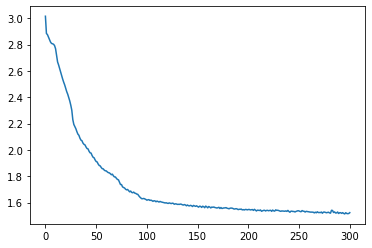

In [25]:
plt.plot(loaded_dict['logs']['test'])

In [26]:
loaded_dict['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 10,
 'c_net_h_dim': 18,
 'clipped_adam': 5,
 'context_dropout': None,
 'context_n_depth': 4,
 'context_n_h_dim': 18,
 'coupling_dropout': None,
 'data_size': 100000,
 'epochs': 3000,
 'flow_depth': 4,
 'l2_reg': None,
 'problem_dim': 2,
 'rich_context_dim': 5}

In [0]:
# Load data
from DEwNF.utils import split_synthetic
batch_size = 500
data_size = 100000
cuda_exp = True
train_dataloader, test_dataloader, obs_scaler, context_scaler = split_synthetic(data_df, batch_size,
                                                    data_size, cuda_exp, random_state=None)

In [0]:
def create_overlay(shape, bounds, flow_dist, obs_scaler):
    cm = matplotlib.cm.get_cmap('cividis')
    
    nlats, nlons = shape
    
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats).float()
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons).float()
    x, y = torch.meshgrid(lats_array, lons_array)

    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1).cuda()
    scaled_points = torch.tensor(obs_scaler.transform(points.cpu())).float().cuda()
    with torch.no_grad():
        data = flow_dist.log_prob(scaled_points).reshape(nlats,nlons).cpu().detach().numpy()
    
    data = np.exp(data).T # this transpose should not be necesary
    data = (data - data.min()) / (data.max() - data.min())

    overlay = cm(data)
    return lons_array, lats_array, overlay, data

In [29]:

## interactive plot
plt.rcParams.update({'font.size': 12})
cond_two_moons = RotatingTwoMoonsConditionalSampler(noise=0.05)

def model_tester3(theta, flow, obs_scaler, context_scaler):
    flow.modules.eval()
    scaled_theta = torch.tensor(context_scaler.transform([[theta]]))
    context = (scaled_theta).float().cuda()
    cond_dist = flow.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    _,_, _, data = create_overlay(shape = (800,800), bounds=bounds, flow_dist = cond_dist, obs_scaler=obs_scaler)  

    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c='r', s=5, alpha=0.5, label="Observations")
    plt.xlim(bounds[0][0],bounds[1][0])
    plt.ylim(bounds[0][1],bounds[1][1])
    test = plt.imshow(data, cmap='cividis', extent=(bounds[1][0],bounds[0][0], bounds[1][1], bounds[0][1]), label="Target distribution")
    plt.legend(framealpha=0.3, fontsize=15, markerscale=6)
    plt.colorbar(test, shrink=0.6)
    plt.show()


interactive_plot = interactive(model_tester3,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow),
                               obs_scaler=fixed(obs_scaler),
                               context_scaler=fixed(context_scaler))
interactive_plot




interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:
with open(flow_model_path, 'rb') as f:
    loaded_dict = pickle.load(f)

In [0]:
loaded_flow = loaded_dict['model']

In [32]:
loaded_dict['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 10,
 'c_net_h_dim': 18,
 'clipped_adam': 5,
 'context_dropout': None,
 'context_n_depth': 4,
 'context_n_h_dim': 18,
 'coupling_dropout': None,
 'data_size': 100000,
 'epochs': 3000,
 'flow_depth': 4,
 'l2_reg': None,
 'problem_dim': 2,
 'rich_context_dim': 5}

In [0]:
plt.rcParams.update({'font.size': 15})

In [0]:
def create_plot(axs, x, dist, trans_idx, trans_type, obs_scaler):
    bounds = [[-3,-2], [3,2]]
    _, _, _, data = create_overlay(shape = (200,200), bounds=bounds, flow_dist = dist, obs_scaler=obs_scaler)  
    axs.scatter(x[:, 0], x[:, 1], c='r', s=5, alpha=0.5, label="Observations")
    axs.set_xlim(-3,3)
    axs.set_ylim(-2,2)
    axs.set_title(f'After transformation number {trans_idx} ({trans_type})', fontsize=15)
    axs.legend(framealpha=0.3, fontsize=12, markerscale=6)
    
    colors = axs.imshow(data, cmap='cividis', extent=(3,-3, 2, -2))
    return colors
    

In [37]:
def rename_trans(name):
    if name == "ConditionedAffineCoupling2()":
        return "Conditioned Affine Coupling"
    if name == "Permute()":
        return "Permute"
    if name == "BatchNorm()":
        return "Batchnorm"
    if name == "InvertedConditionedPlanar()":
        return "Conditioned Planar Transformation"

def model_tester4(theta, flow):
    flow.modules.eval()
    scaled_theta = torch.tensor(context_scaler.transform([[theta]]))
    context = (scaled_theta).float().cuda()
    cond_dist = flow.condition(context)
    x, _= cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    n_trans = len(cond_dist.transforms)
    fig, axs = plt.subplots(((n_trans) // 2) +1 , 2,  figsize=(25,n_trans*5),gridspec_kw = {'wspace':0, 'hspace':0})

    colors = create_plot(axs[0, 0], x, cond_dist.base_dist.to_event(1), 0, 'Base distribution', obs_scaler)
    plt.colorbar(colors, ax=axs[0,0], shrink=0.8)
    for i in range(0, n_trans):
        temp_dist = TransformedDistribution(cond_dist.base_dist, cond_dist.transforms[0:i+1])
        trans_type = rename_trans(cond_dist.transforms[i].__str__())
        colors = create_plot(axs[(i+1) // 2, (i+1) % 2 ], x, temp_dist, i+1, trans_type, obs_scaler)
        plt.colorbar(colors, ax=axs[(i+1) // 2, (i+1) % 2 ],shrink=0.8)
    if n_trans % 2 == 0:
        fig.delaxes(axs[n_trans//2, 1])

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow))
interactive_plot


interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               moon=(0.,1.,1),
                               trans_1=(-4.,4.),
                               trans_2=(-4.,4.),
                               flow_dist=fixed(loaded_flow.dist))
interactive_plot


ValueError: ignored